In [4]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, MaxPool1D,MaxPooling1D ,Flatten, Dense, Dropout, Softmax
from tensorflow.keras.optimizers import Adam , SGD, RMSprop,Adamax,Nadam
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix



%matplotlib inline

Using TensorFlow backend.


In [5]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [3]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


In [6]:
path = 'mitbih_database/'
window_size = 180


classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [7]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [8]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

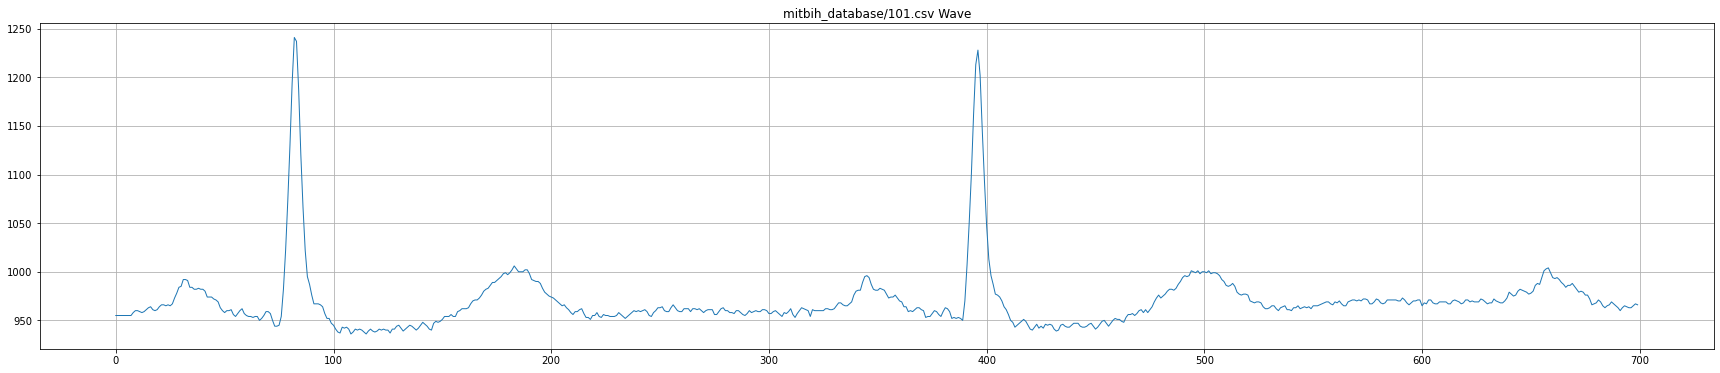

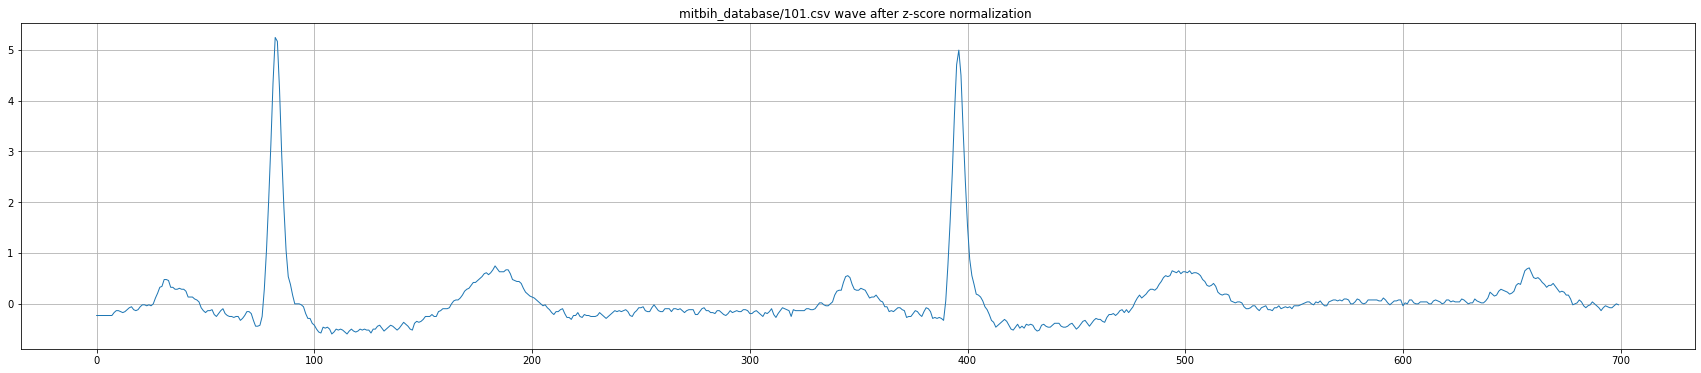

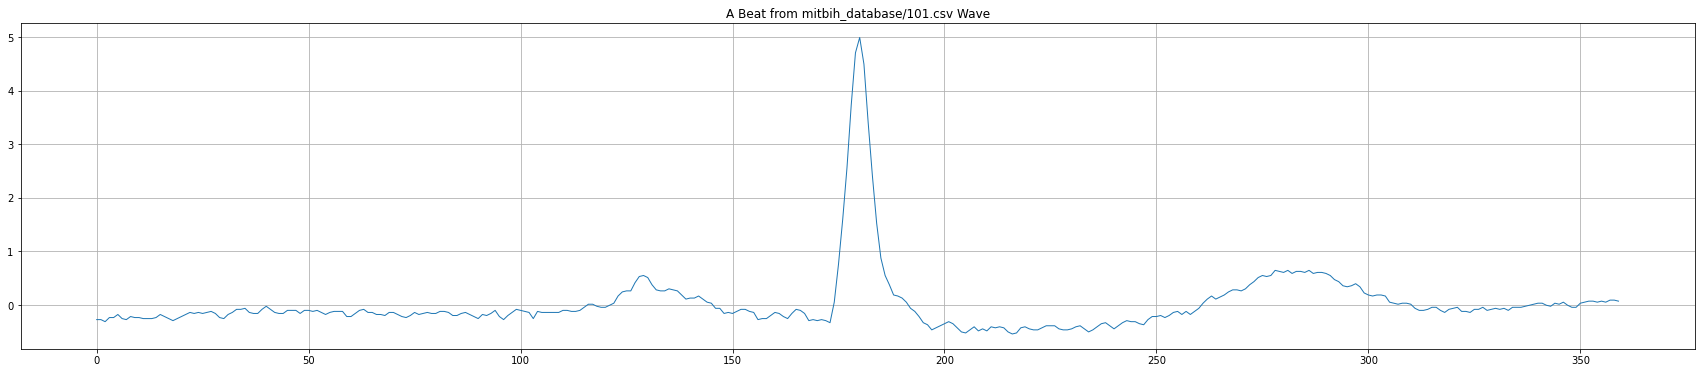

(100012, 360) (100012,)


In [9]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    

        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [10]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


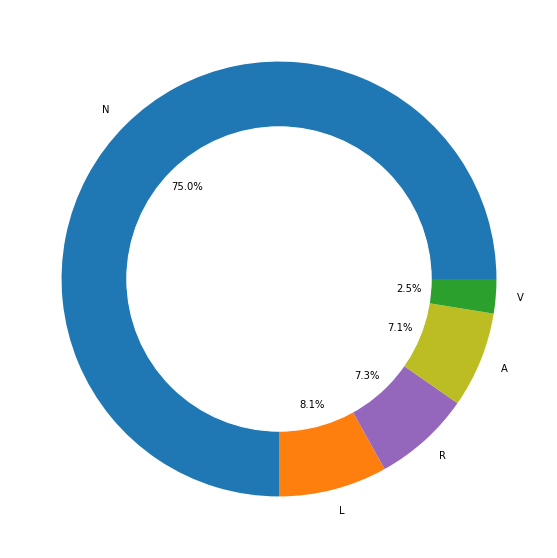

In [11]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [16]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 360, dtype: int64


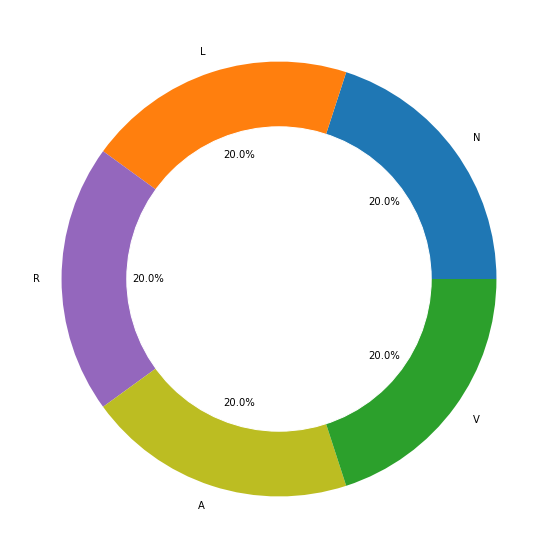

In [17]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [18]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [19]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [20]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


In [15]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation='relu', input_shape = (360,1)))
model.add(Conv1D(filters=64, kernel_size=(3,), padding='same', activation='relu')) 
model.add(Conv1D(filters=128, kernel_size=(5,), padding='same', activation='relu'))    

model.add(MaxPool1D(pool_size=(3,), strides=2, padding='same'))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(units = 512, activation='relu'))
model.add(Dense(units = 1024, activation='relu'))
model.add(Dense(units = 5, activation='softmax'))



In [16]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [17]:
history = model.fit(train_x, train_y, batch_size=36, epochs=60, verbose=1, validation_data=(test_x, test_y))

Train on 20000 samples, validate on 5000 samples
Epoch 1/60
20000/20000 [==============================] - 7s 336us/step - loss: 0.2392 - accuracy: 0.9197 - val_loss: 0.1049 - val_accuracy: 0.9676
Epoch 2/60
20000/20000 [==============================] - 5s 267us/step - loss: 0.0771 - accuracy: 0.9745 - val_loss: 0.1285 - val_accuracy: 0.9616
Epoch 3/60
20000/20000 [==============================] - 5s 274us/step - loss: 0.0544 - accuracy: 0.9821 - val_loss: 0.0497 - val_accuracy: 0.9842
Epoch 4/60
20000/20000 [==============================] - 6s 276us/step - loss: 0.0367 - accuracy: 0.9888 - val_loss: 0.0646 - val_accuracy: 0.9808
Epoch 5/60
20000/20000 [==============================] - 6s 275us/step - loss: 0.0228 - accuracy: 0.9927 - val_loss: 0.0618 - val_accuracy: 0.9836
Epoch 6/60
20000/20000 [==============================] - 6s 278us/step - loss: 0.0257 - accuracy: 0.9922 - val_loss: 0.0702 - val_accuracy: 0.9830
Epoch 7/60
20000/20000 [==============================] - 6s 28

Epoch 56/60
20000/20000 [==============================] - 6s 292us/step - loss: 2.1546e-04 - accuracy: 0.9999 - val_loss: 0.1174 - val_accuracy: 0.9896
Epoch 57/60
20000/20000 [==============================] - 6s 295us/step - loss: 0.0081 - accuracy: 0.9989 - val_loss: 0.1023 - val_accuracy: 0.9906
Epoch 58/60
20000/20000 [==============================] - 6s 292us/step - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.1358 - val_accuracy: 0.9898
Epoch 59/60
20000/20000 [==============================] - 6s 290us/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.1448 - val_accuracy: 0.9906
Epoch 60/60
20000/20000 [==============================] - 6s 297us/step - loss: 0.0241 - accuracy: 0.9962 - val_loss: 0.1125 - val_accuracy: 0.9864


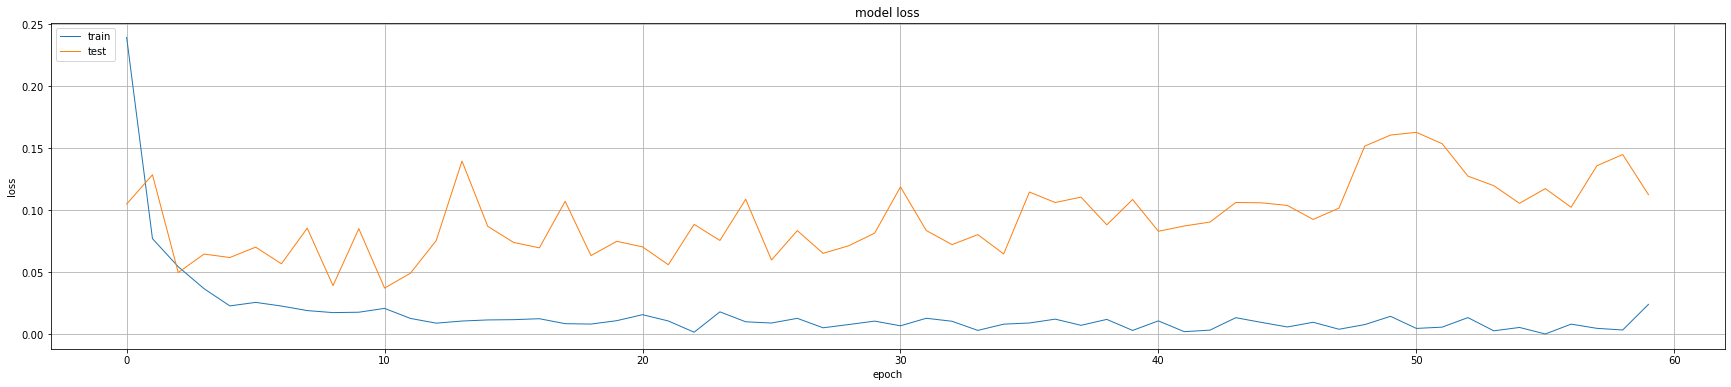

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

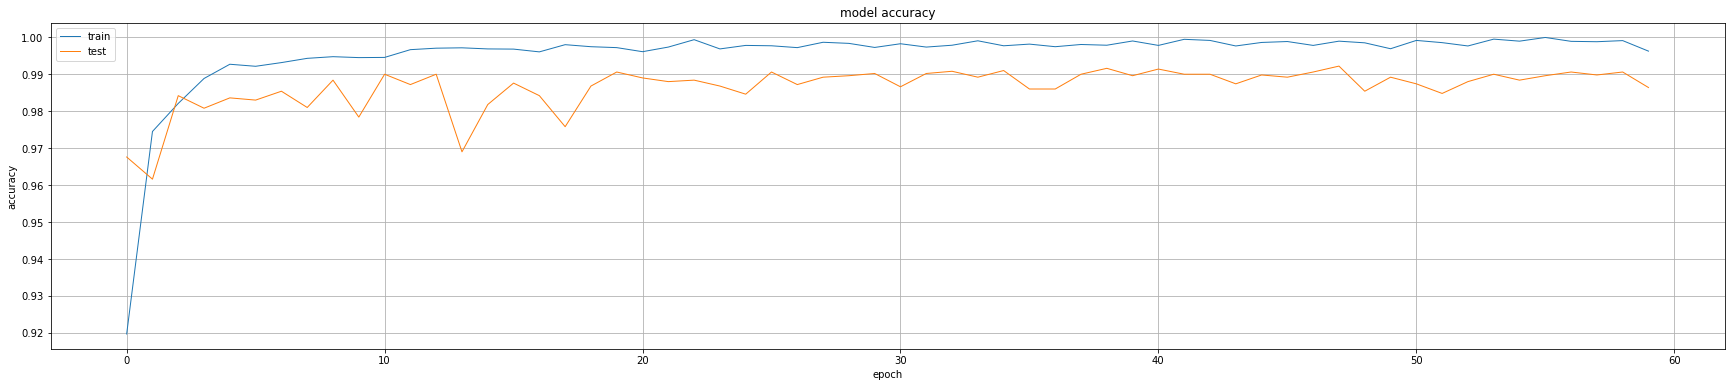

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

5000/5000 [==============================] - 1s 117us/step
Test Loss: 0.11248393761741526
Test accuracy: 0.9864000082015991


In [21]:
predictions = model.predict(test_x)
print(predictions)

[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [9.9999714e-01 1.8863618e-08 5.6430654e-12 2.7367551e-06 8.1619589e-08]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
 ...
 [2.9136921e-35 0.0000000e+00 1.0000000e+00 1.9362264e-28 4.3116196e-33]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 2.6985076e-37]
 [3.2386298e-33 1.4661043e-33 5.2160255e-33 1.0000000e+00 9.0358797e-28]]


In [22]:
y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[1011    2    2    7    1]
 [   1 1000    0    0    2]
 [   7    0  970    1    0]
 [  17    0    1  953    0]
 [  15    9    2    2  997]]


In [23]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5
F1 = 2*((Precision*Recall)/(Precision+Recall))
print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)
print("F1: ",F1)

Accuracy:  0.99448
Precision:  0.9862488290835888
Recall:  0.9865096541850153
TNR:  0.9965525707369121
FNR:  0.013490345814984681
FPR:  0.0034474292630879296
NPV:  0.9965420436735325
F1:  0.9863792243920158


<AxesSubplot:>

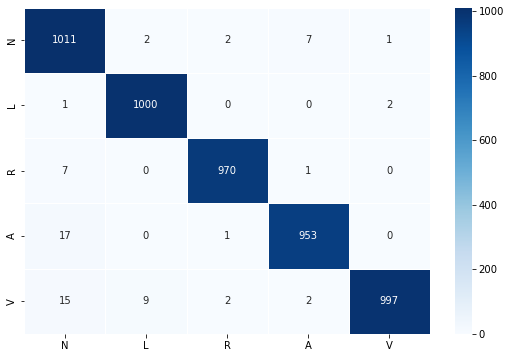

In [24]:
import seaborn as sn
labels = ['N', 'L', 'R', 'A', 'V']
df_cm = pd.DataFrame(matrix, index = labels,
                  columns = labels)
fig = plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
sn.heatmap(df_cm,annot = True,cmap = "Blues",fmt="d",linewidths=.5)

In [25]:
array = [[ 958,2,1,25,5],
         [1,1007,    0,    2,    1],
         [   3  ,  0,  983,    1,    0],
         [  25  ,  0 ,   3,  950,    1],
         [  21   , 6,    1 ,   9,  995]]

<AxesSubplot:>

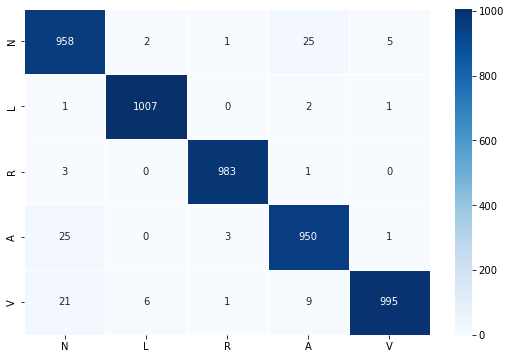

In [26]:
import seaborn as sn
labels = ['N', 'L', 'R', 'A', 'V']
df_cm = pd.DataFrame(array, index = labels,
                  columns = labels)
fig = plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
sn.heatmap(df_cm,annot = True,cmap = "Blues",fmt="d",linewidths=.5)

In [27]:
array1 = [[ 937 ,   2,    0,   14,    2],
 [   1, 1025 ,   0,    1,    1],
 [   2 ,   0,  977,    1,    0],
 [  15 ,   1 ,   4,  979,    1],
 [   4  ,  1 ,   1 ,   1, 1030]]

<AxesSubplot:>

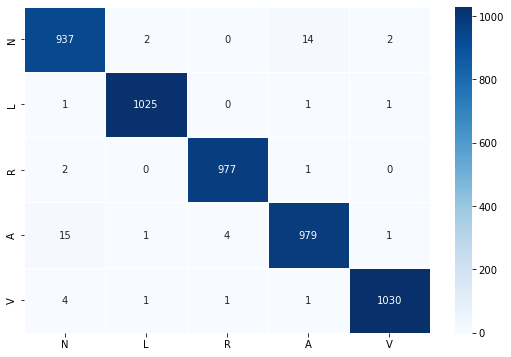

In [28]:
import seaborn as sn
labels = ['N', 'L', 'R', 'A', 'V']
df_cm = pd.DataFrame(array1, index = labels,
                  columns = labels)
fig = plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
sn.heatmap(df_cm,annot = True,cmap = "Blues",fmt="d",linewidths=.5)

In [29]:
Precision=  0.9905171254477162
Recall= 0.9905171254477162
F1 = 2*((Precision*Recall)/(Precision+Recall))
F1

0.9905171254477162



# sparse_categorical_crossentropy


In [21]:
model2 = Sequential()

model2.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation='relu', input_shape = (360,1)))
model2.add(Conv1D(filters=64, kernel_size=(3,), padding='same', activation='relu')) 
model2.add(Conv1D(filters=128, kernel_size=(5,), padding='same', activation='relu'))    

model2.add(MaxPool1D(pool_size=(3,), strides=2, padding='same'))
model2.add(Dropout(0.4))

model2.add(Flatten())

model2.add(Dense(units = 512, activation='relu'))
model2.add(Dense(units = 1024, activation='relu'))
model2.add(Dense(units = 5, activation='softmax'))



In [22]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [23]:
history = model2.fit(train_x, train_y, batch_size=36, epochs=60, verbose=1, validation_data=(test_x, test_y))

ValueError: Error when checking target: expected dense_3 to have shape (1,) but got array with shape (5,)

In [ ]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
predictions = model.predict(test_x)
print(predictions)

In [ ]:
y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

In [ ]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5
F1 = 2*((Precision*Recall)/(Precision+Recall))
print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)
print("F1: ",F1)

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# poisson

In [24]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation='relu', input_shape = (360,1)))
model.add(Conv1D(filters=64, kernel_size=(3,), padding='same', activation='relu')) 
model.add(Conv1D(filters=128, kernel_size=(5,), padding='same', activation='relu'))    

model.add(MaxPool1D(pool_size=(3,), strides=2, padding='same'))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(units = 512, activation='relu'))
model.add(Dense(units = 1024, activation='relu'))
model.add(Dense(units = 5, activation='softmax'))



In [25]:
model.compile(loss='poisson', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [26]:
history = model.fit(train_x, train_y, batch_size=36, epochs=60, verbose=1, validation_data=(test_x, test_y))

Train on 20000 samples, validate on 5000 samples
Epoch 1/60
20000/20000 [==============================] - 7s 356us/step - loss: 0.2500 - accuracy: 0.9172 - val_loss: 0.2178 - val_accuracy: 0.9700
Epoch 2/60
20000/20000 [==============================] - 5s 263us/step - loss: 0.2171 - accuracy: 0.9711 - val_loss: 0.2122 - val_accuracy: 0.9794
Epoch 3/60
20000/20000 [==============================] - 5s 262us/step - loss: 0.2105 - accuracy: 0.9827 - val_loss: 0.2121 - val_accuracy: 0.9830
Epoch 4/60
20000/20000 [==============================] - 5s 261us/step - loss: 0.2069 - accuracy: 0.9889 - val_loss: 0.2094 - val_accuracy: 0.9844
Epoch 5/60
20000/20000 [==============================] - 5s 262us/step - loss: 0.2056 - accuracy: 0.9916 - val_loss: 0.2121 - val_accuracy: 0.9824
Epoch 6/60
20000/20000 [==============================] - 5s 266us/step - loss: 0.2048 - accuracy: 0.9926 - val_loss: 0.2115 - val_accuracy: 0.9842
Epoch 7/60
20000/20000 [==============================] - 5s 26

Epoch 56/60
20000/20000 [==============================] - 6s 311us/step - loss: 0.2026 - accuracy: 0.9980 - val_loss: 0.2229 - val_accuracy: 0.9880
Epoch 57/60
20000/20000 [==============================] - 6s 306us/step - loss: 0.2012 - accuracy: 0.9991 - val_loss: 0.2173 - val_accuracy: 0.9912
Epoch 58/60
20000/20000 [==============================] - 6s 309us/step - loss: 0.2020 - accuracy: 0.9986 - val_loss: 0.2411 - val_accuracy: 0.9776
Epoch 59/60
20000/20000 [==============================] - 6s 307us/step - loss: 0.2044 - accuracy: 0.9967 - val_loss: 0.2205 - val_accuracy: 0.9890
Epoch 60/60
20000/20000 [==============================] - 6s 313us/step - loss: 0.2009 - accuracy: 0.9995 - val_loss: 0.2219 - val_accuracy: 0.9890


In [27]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

5000/5000 [==============================] - 1s 101us/step
Test Loss: 0.2218679482460022
Test accuracy: 0.9890000224113464


In [28]:
predictions = model.predict(test_x)
print(predictions)

[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 9.0343573e-37 1.3396793e-31 7.2089275e-35 1.0000000e+00]
 ...
 [8.5147389e-10 2.7794593e-27 5.6698255e-20 1.0000000e+00 5.3114945e-13]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


In [29]:
y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[1033    6    0   11    3]
 [   4  963    0    0    0]
 [   0    0 1000    5    0]
 [   7    0    2  975    0]
 [   4    7    1    5  974]]


In [30]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5
F1 = 2*((Precision*Recall)/(Precision+Recall))
print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)
print("F1: ",F1)

Accuracy:  0.9955999999999999
Precision:  0.9891188575345344
Recall:  0.989044272428138
TNR:  0.9972441685612177
FNR:  0.010955727571862127
FPR:  0.0027558314387823844
NPV:  0.9972495799560128
F1:  0.9890815635752495


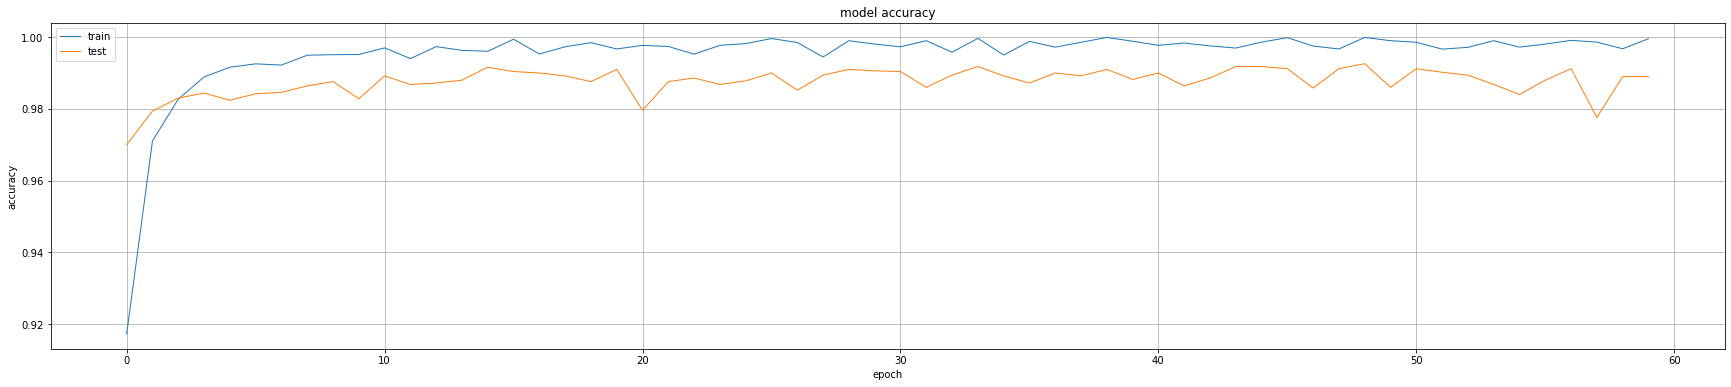

In [31]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

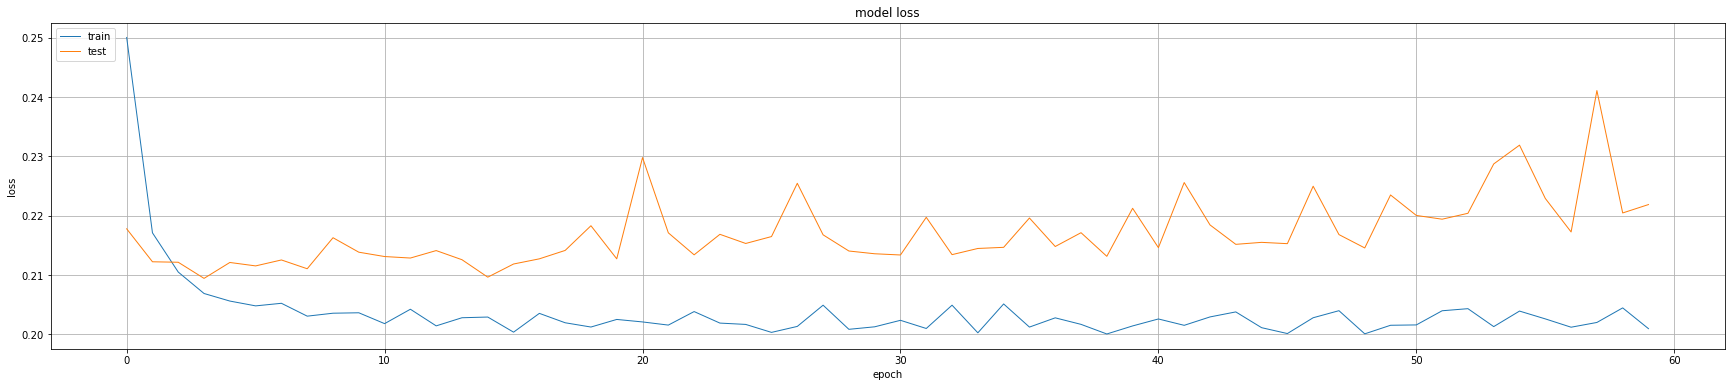

In [32]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# KLdivergence

In [37]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation='relu', input_shape = (360,1)))
model.add(Conv1D(filters=64, kernel_size=(3,), padding='same', activation='relu')) 
model.add(Conv1D(filters=128, kernel_size=(5,), padding='same', activation='relu'))    

model.add(MaxPool1D(pool_size=(3,), strides=2, padding='same'))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(units = 512, activation='relu'))
model.add(Dense(units = 1024, activation='relu'))
model.add(Dense(units = 5, activation='softmax'))



In [40]:
model.compile(loss='kullback_leibler_divergence', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [41]:
history = model.fit(train_x, train_y, batch_size=36, epochs=60, verbose=1, validation_data=(test_x, test_y))

Train on 20000 samples, validate on 5000 samples
Epoch 1/60
20000/20000 [==============================] - 6s 292us/step - loss: 0.2337 - accuracy: 0.9179 - val_loss: 0.1482 - val_accuracy: 0.9526
Epoch 2/60
20000/20000 [==============================] - 5s 267us/step - loss: 0.0794 - accuracy: 0.9737 - val_loss: 0.0619 - val_accuracy: 0.9822
Epoch 3/60
20000/20000 [==============================] - 5s 267us/step - loss: 0.0509 - accuracy: 0.9837 - val_loss: 0.0897 - val_accuracy: 0.9744
Epoch 4/60
20000/20000 [==============================] - 5s 267us/step - loss: 0.0370 - accuracy: 0.9893 - val_loss: 0.0439 - val_accuracy: 0.9888
Epoch 5/60
20000/20000 [==============================] - 5s 267us/step - loss: 0.0279 - accuracy: 0.9914 - val_loss: 0.0578 - val_accuracy: 0.9850
Epoch 6/60
20000/20000 [==============================] - 5s 267us/step - loss: 0.0301 - accuracy: 0.9909 - val_loss: 0.0701 - val_accuracy: 0.9806
Epoch 7/60
20000/20000 [==============================] - 5s 26

Epoch 56/60
20000/20000 [==============================] - 6s 307us/step - loss: 0.0076 - accuracy: 0.9988 - val_loss: 0.1348 - val_accuracy: 0.9866
Epoch 57/60
20000/20000 [==============================] - 6s 305us/step - loss: 0.0141 - accuracy: 0.9979 - val_loss: 0.1412 - val_accuracy: 0.9866
Epoch 58/60
20000/20000 [==============================] - 6s 299us/step - loss: 0.0048 - accuracy: 0.9994 - val_loss: 0.1082 - val_accuracy: 0.9898
Epoch 59/60
20000/20000 [==============================] - 6s 298us/step - loss: 0.0103 - accuracy: 0.9985 - val_loss: 0.1646 - val_accuracy: 0.9856
Epoch 60/60
20000/20000 [==============================] - 6s 303us/step - loss: 0.0329 - accuracy: 0.9960 - val_loss: 0.1625 - val_accuracy: 0.9834


In [42]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

5000/5000 [==============================] - 0s 95us/step
Test Loss: 0.16253127052228378
Test accuracy: 0.9833999872207642


In [43]:
predictions = model.predict(test_x)
print(predictions)

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [44]:
y_pred = (predictions > 0.5)
matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[1003    4    7   31    8]
 [   3  961    0    2    1]
 [   0    0 1004    1    0]
 [   7    0    3  971    3]
 [   6    2    1    4  978]]


In [45]:
Accuracy = []
Precision = []
Recall = []
TNR = []
FNR = []
FPR = []
NPV = []
for i in range(matrix.shape[0]):
    TP = matrix[i,i]
    FP = matrix[i,:].sum() - TP
    FN = matrix[:,i].sum() - TP
    TN = matrix.sum().sum() - TP - FP - FN
    Accuracy.append((TP+TN)/matrix.sum().sum())
    Precision.append(TP/(TP+FP))
    Recall.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))
    FNR.append(FN/(FN+TP))
    FPR.append(FP/(FP+TN))
    NPV.append(TN/(TN+FN))
Accuracy = sum(Accuracy)/5
Precision = sum(Precision)/5
Recall = sum(Recall)/5
TNR = sum(TNR)/5
FNR = sum(FNR)/5
FPR = sum(FPR)/5
NPV = sum(NPV)/5
F1 = 2*((Precision*Recall)/(Precision+Recall))
print("Accuracy: ",Accuracy)
print("Precision: ",Precision)
print("Recall: ",Recall)
print("TNR: ",TNR)
print("FNR: ",FNR)
print("FPR: ",FPR)
print("NPV: ",NPV)
print("F1: ",F1)

Accuracy:  0.99336
Precision:  0.9837974785300847
Recall:  0.983494774725488
TNR:  0.9958404900166815
FNR:  0.016505225274512057
FPR:  0.004159509983318444
NPV:  0.995849940742359
F1:  0.983646103339535


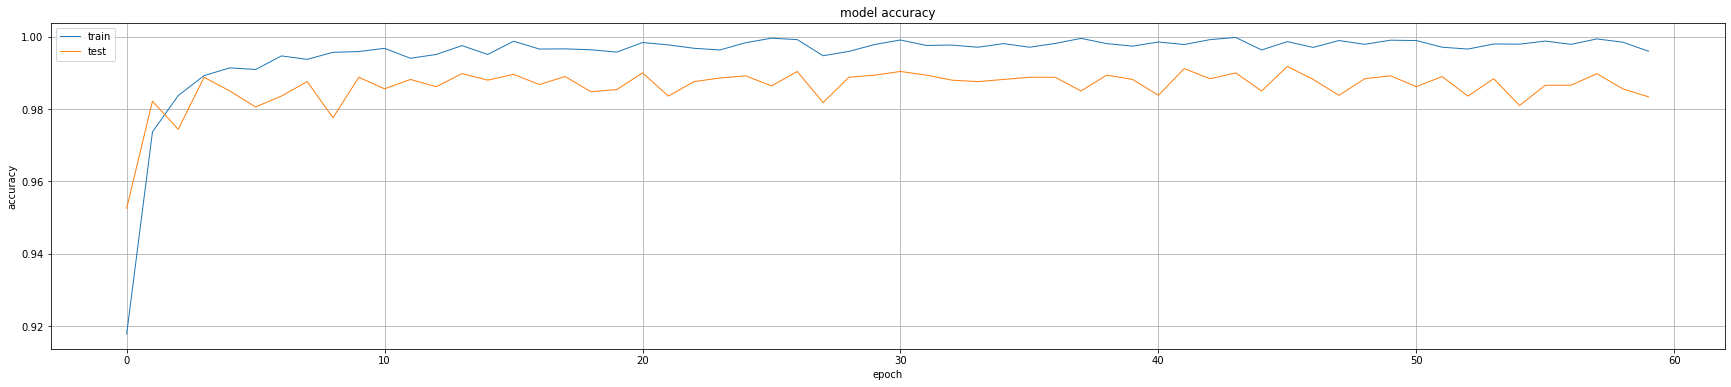

In [46]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

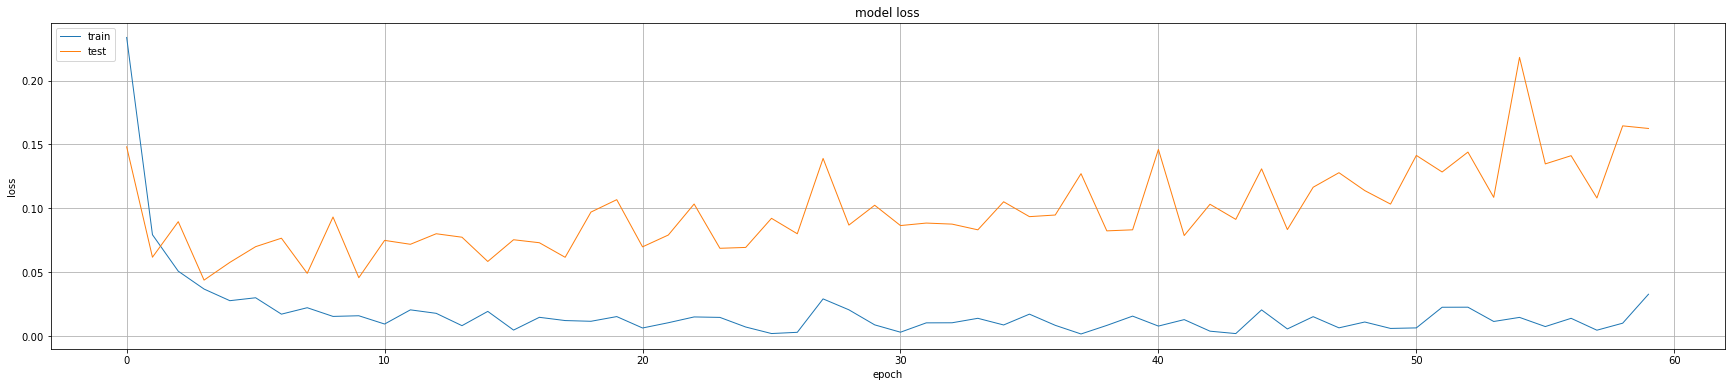

In [47]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()